# What is Graph Coarsening?

One important operation of Convolutional Neural Networks, is the max-pooling operation that allows to lower the dimension of the space, and to achieve some kind of spatial invariance.

To apply the same scheme on graph, the authors propose to follow a 3 steps method:
1. Compute a coarsened version of the graph that includes less nodes and less edges, but keep the overall structure 
2. Link the new nodes with their parents in the larger graph
3. Pool the graph signal using those links

The first important step is to compute the coarsened version of the graph. Note that this step is performed once and for all, when the CNN structure is created.

## Experiments

We again, consider an grid graph with an mnist signal.

In [6]:
import pygsp
import numpy
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
numpy.set_printoptions(threshold=numpy.nan)
%matplotlib inline

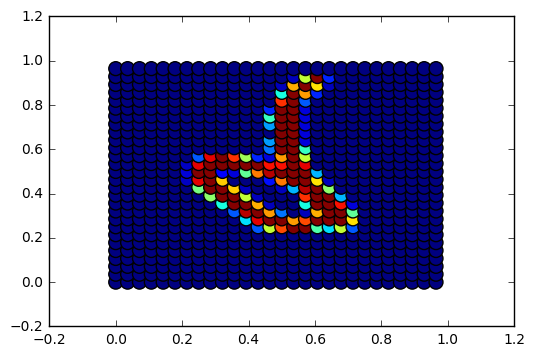

In [7]:
mnist = scipy.misc.imread("mnist.png", flatten=True)/255
gsz = mnist.shape[0]
mnist = numpy.reshape(mnist,[mnist.size,1])
mnist = numpy.float64(mnist)
g = pygsp.graphs.Grid2d(gsz)
pygsp.plotting.plot_signal(g, mnist)

In [51]:
def computeCoarsening(W):
    """
    Compute a coarsened graph 
    Input:
        + W: Weight matrix of graph
    Output:
        + W_c: Weight matrix of coarsened graph
        + Tr: Coarsening transfer matrix
    """
    
    # We instantiate useful variables
    nb_nodes = W.shape[0]
    marking = numpy.ones([nb_nodes, 1])
    couples = numpy.int16(-numpy.ones([nb_nodes,2]))
    
    # We compute the normalized local cut vals
    deg = W.sum(axis=0)
    Deg = numpy.tile(deg,[nb_nodes,1])
    W_n = numpy.multiply(W,((1/Deg)+(1/Deg.T)))
    
    # We loop through the nodes to get couples
    for i in range(0,nb_nodes+1):
        # Checking if unmarked nodes remains
        if sum(marking)[0] == 0:
            break
        # Picking randomly unmarked node
        start_node = numpy.random.choice(numpy.where(marking==1)[0])
        # We check if neighborings nodes are marked
        if sum(numpy.multiply(W[:,start_node],marking))[0]==0:
            marking[start_node]=0
            couples[i][0] = start_node
            couples[i][1] = start_node
        else:
            friend_node = numpy.argmax(numpy.multiply(W[:,start_node],marking))
            couples[i][0] = start_node
            couples[i][1] = friend_node
            marking[start_node]=0
            marking[friend_node]=0
    
    couples = couples[numpy.sum(couples,axis=1)!=-2]
    
    # We do a sanity check
    if True:   
        for i in range(0,couples.shape[0]):
            for j in range(0,couples.shape[0]):
                wcgw = (couples[i].max()==couples[j].max())|(couples[i].min()==couples[j].min())
                if (i!=j) & wcgw:
                    print("Error for i=%i and j=%i"%(i,j))
    
    # We instantiate output variables
    W_c = numpy.zeros([couples.shape[0],couples.shape[0]])
    Tr = numpy.zeros([couples.shape[0],nb_nodes])
    
    # We loop through the nodes to create the new weight matrix
    for i in range(0,couples.shape[0]):
        Tr[i,couples[i][0]]=1
        Tr[i,couples[i][1]]=1
        for j in range(i+1,couples.shape[0]):
            weig = numpy.sum(W[couples[i]][:,couples[j]])
            W_c[i,j] = weig
    
    W_c = W_c+W_c.T
            
    return W_c, Tr   
    
    
    
def maxPoolSignal(x,Tr):
    """
    Compute max pooling of a signal given the Coarsening Transfer Matrix
    Input:
        + x: unpooled signal
        + Tr: Coarsening Transfer Matrix
    Output:
        + x_c: coarsened signal
    """
    
    # We only have to apply this method to compute the pooling
    x_c = numpy.float32(numpy.max(numpy.multiply(Tr,x),axis=1))
    
    return x_c
    
def computeCoarsenedCoords(unc_coords, Tr):
    """
    Compute the coarsened coordinates given the Coarsening Transfer Matrix
    Input:
        + unc_coords: coordinates of uncoarsened nodes
        + Tr: Coarsening Transfer Matrix
    Output:
        + c_coords: coordinates of coarsened nodes
    """
    
    # We instantiate indexes 
    nb_nodes = unc_coords.shape[0]
    idx = numpy.uint32(numpy.linspace(0,nb_nodes-1, nb_nodes))
    idx =numpy.reshape(idx,[1,nb_nodes])
    
    # We compute lists of max and min indices
    max_idx = numpy.uint16(numpy.max(numpy.multiply(Tr,idx),axis=1))    
    min_idx = numpy.uint16(numpy.min(numpy.multiply(Tr,idx),axis=1))
    
    # We construct a 3 dimensionnal array coords with coordinates of both points in the 3rd dim
    coords = numpy.ndarray([max_idx.shape[0],unc_coords.shape[1],2])
    coords[:,:,0]=unc_coords[min_idx]
    coords[:,:,1]=unc_coords[max_idx]
    
    # We average over the 3rd dim
    coords = numpy.mean(coords,axis=2)
    
    return coords
    

In [52]:
%%time
W_c,Tr = computeCoarsening(g.W.todense())

CPU times: user 5.27 s, sys: 0 ns, total: 5.27 s
Wall time: 5.27 s


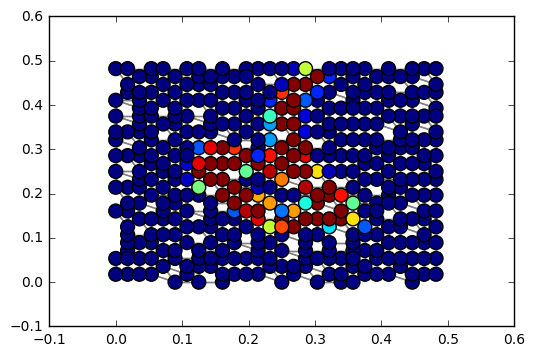

In [53]:
g_c = pygsp.graphs.Graph(W_c)
g_c.coords = computeCoarsenedCoords(g.coords,Tr)
x_p = maxPoolSignal(mnist.T,Tr)
pygsp.plotting.plot_signal(g_c,x_p)